# Chance-constrained programming: portfolio optimization example

In [18]:
# ENV["GUROBI_HOME"] = "/Library/gurobi952/macos_universal2/"
# # import Pkg
# Pkg.add("Gurobi")
# Pkg.build("Gurobi")
# Pkg.add("Dates")
# Pkg.add("CSV")
# Pkg.add("DataFrames")

   Resolving package versions...


    Updating `~/.julia/environments/v1.9/Project.toml`
⌃ [2e9cd046] + Gurobi v0.11.3
    Updating `~/.julia/environments/v1.9/Manifest.toml`
⌃

 [2e9cd046] + Gurobi v0.11.3
        Info Packages marked with ⌃ have new versions available and may be upgradable.


    Building Gurobi → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/87c018cbd2fd33e6d2462d486abee53a27c91c91/build.log`


In [1]:
using LinearAlgebra
using JuMP
using HiGHS, Gurobi
using Distributions
using Random
using CSV, DataFramesMeta
using Dates
using Statistics
using Plots

## HW2

Sample Average Approximation Method for Chance Constrained Programming : Theory and Applications”, 2009, Section 3, en s ́electionnant 10 actifs depuis la base de donn ́ees disponible sur Kaggle `a l’adresse https: //www.kaggle.com/datasets/jacksoncrow/stock-market-dataset.

Note : vous pouvez partir de https://www.kaggle.com/code/artemburenok/ stock-analysis-monte-carlo-build-portfolio pour analyser les donn ́ees.

Adapted from Stephen Boyd and Lieven Vandenberghe, "Convex Optimization", Cambridge University Press, 2004, Section 4.7.6, p. 187.

We consider an investiment portfolio with $n$ assets and random returns, except the last one. We assume that the $n-1$ first returns follow a multivariate distribution with known mean and covariance matrix. The last asset is a risk-free investment product, with a fixed return.

The assets characteristics are detailed below.

In [2]:
company_list = ["CSCO", "UNT", "SBGI", "UFCS", "GFED", "AIRT", "SITC", "NXN", "TRNS", "NTZ"]
n = length(company_list)


10

## Data Pipeline

### Initial Preprocessing

In [96]:
dir_path = "../data/stocks/"
companies = Dict{String, DataFrame}()
# companies = Dict{}()
for company in company_list
    fn = dir_path * company * ".csv"
    companies[company] = CSV.read(fn, DataFrame, select=["Date", "Adj Close"])
end

In [97]:
# If Initialize to same start and end date  
first_end, last_start = DateTime(2023, 11, 14), DateTime(1900, 11, 14)
for (company, df) in companies

    start_date = minimum(df.Date)
    end_date = maximum(df.Date)

    println("$(company): $(start_date) to $(end_date)")
    if start_date > last_start
        last_start = start_date
        println("last_start: $(start_date)")
    end
    if end_date < first_end
        first_end = end_date
        println("first_end: $(end_date)")
    end
end

for (company, df) in companies
    df = df[df.Date .>= last_start, :]
    df = df[df.Date .<= first_end, :]
    if company == "CAT"    
        df = deleteat!(df, findall(df.Date .== Date(2016, 01, 18))) # CAT data contains extra date
    end
    companies[company] = df
end

AIRT: 1984-04-24 to 2020-04-01
last_start: 1984-04-24


first_end: 2020-04-01
NTZ: 1993-05-13 to 2020-04-01
last_start: 1993-05-13


UFCS: 1980-03-18 to 2020-04-01
GFED: 1995-04-10 to 2020-04-01
last_start: 1995-04-10
TRNS: 1977-12-05 to 2020-04-01
CSCO: 1990-02-16 to 2020-04-01
SITC: 1993-02-02 to 2020-04-01
NXN: 1992-06-19 to 2020-04-01
UNT: 1979-04-06 to 2020-04-01
SBGI: 1995-06-07 to 2020-04-01
last_start: 1995-06-07


In [98]:
for (c, df) in companies
    println("$(c): $(size(df))")
end

AIRT: (6249, 2)
NTZ: (6249, 2)
UFCS: (6249, 2)
GFED: (6249, 2)
TRNS: (6249, 2)
CSCO: (6249, 2)
SITC: (6249, 2)
NXN: (6249, 2)
UNT: (6249, 2)
SBGI: (6249, 2)


In [99]:
# Check dates alignment
row_cnt = 0
test_df = DataFrame()
for (c, df) in companies
    if row_cnt == 0 
        println("Set row cnt to $(size(df)[1]) with  $(c)")
        row_cnt = size(df)[1]
        test_df = df
    elseif row_cnt != size(df)[1]
        println("$(c) has $(size(df)[1]) rows")
        println(setdiff(Set(df[!, :Date]), Set(test_df[!, :Date])))
    end
end


Set row cnt to 6249 with  AIRT


In [100]:
# Calculate returns
for (company, df) in companies
    df[!, :Return] = [0.0; diff(df[!, :"Adj Close"]) ./ df[1:end-1, :"Adj Close"]]
    companies[company] = df
end
out_path = "../data/clean/"
for (c, df) in companies
    fn = out_path * c * ".csv"
    CSV.write(fn, df)
end

### Get the monthly return

In [3]:
monthly_path = "../data/clean/monthly/"
companies = Dict{String, DataFrame}()
for c in company_list
    fn = monthly_path * c * ".csv"
    companies[c] = CSV.read(fn, DataFrame, dateformat="yyyy-mm-dd")
end

### Get Clean Data

In [42]:
dir_path = "../data/clean/"
companies = Dict{String, DataFrame}()
# companies = Dict{}()
for company in company_list
    fn = dir_path * company * ".csv"
    companies[company] = CSV.read(fn, DataFrame)
end

## Additional Functions

In [4]:
function calc_mean_cov(returns_N)
    # Calculate mean and covariance

    company_list = collect(keys(companies))
    max_N = size(companies[company_list[1]])[1]

    # if N == 0
    #     N = max_N
    # end

    μ = zeros(length(company_list))
    Σ = zeros(length(company_list), length(company_list))
    
    for (i, company) in enumerate(company_list)

        μ[i] = mean(returns_N[company])

        for (j, company2) in enumerate(company_list)
            Σ[i, j] = cov(returns_N[company], returns_N[company2])
            if abs(Σ[i, j]) > .99; println("$(company), $(company2)"); end
        end
    end

    return μ, Σ
end

calc_mean_cov (generic function with 1 method)

In [5]:
function select_samples(N, companies, rand_sampling=false, sel=false)
    # Select N samples from companies
    # Return a Dict of Vector{Float64} containing the returns
    companies_N = Dict{String, Vector{Float64}}()
    row_cnt = size(companies[company_list[1]])[1]
    for (c, df) in companies
        if rand_sampling
            idx_N = sample(1:size(df)[1], N; replace = false, ordered = true)
            df_N = df[!, :Return][idx_N]
        elseif sel 
            df_N = df[!, :Return][row_cnt-(N-1):row_cnt]
        else
            df_N = df[!, :Return]
        end
        companies_N[c] = df_N

    end
    return companies_N
end

select_samples (generic function with 3 methods)

In [6]:
# Estimate the probability to have a negative return and the resulting expected shortfall.
function expectedshortfall(p:: Vector, d:: Distribution, v::Float64 = 1, M:: Int = 1000000) # M = 1000000
    
    loss = 0
    vloss = 0
    for i = 1:M
        ξ = rand(d)  #[rand(d); μ[n]]
        ret = dot(p, ξ)
        if ret < v
            loss += 1
            vloss += ret
        end
    end

    return loss/M, vloss/loss
end

expectedshortfall (generic function with 3 methods)

## Model 1/7
SAA with
- Normal
- γ = 0
- $\alpha$ = .1
- $\beta$ = .01
- N = [30, 40, 50, ..., 200] + 183      (Sample Sizes)

#

In [20]:
for (c, df) in companies
    df[!, :Return] .- 1
    companies[c] = df
end

In [7]:
companies["CSCO"][1:5, :]

,Date,Return
,Date,Float64
1,1995-06-30,1.00729
2,1995-07-31,1.00533
3,1995-08-31,1.00757
4,1995-09-30,1.00279
5,1995-10-31,1.00577


In [8]:
function ind(v::Float64, val::Float64)
    if v < val
        return 1
    else
        return 0
    end
end

ind (generic function with 1 method)

In [56]:
returns_N = select_samples(30, companies, false, true)

Dict{String, Vector{Float64}} with 10 entries:
  "SBGI" => [1.00385, 1.0054, 0.999345, 0.995347, 0.996731, 0.995507, 0.999095,…
  "NTZ"  => [0.990046, 1.00053, 1.00046, 1.00282, 0.999881, 1.00046, 0.998878, …
  "UFCS" => [1.00231, 0.997465, 0.997717, 1.00157, 1.00386, 1.00238, 1.0033, 1.…
  "GFED" => [1.00115, 1.00132, 0.999974, 1.00107, 1.0017, 1.00026, 1.00066, 1.0…
  "TRNS" => [1.00495, 1.00111, 1.00507, 1.0001, 1.00004, 1.00271, 1.00461, 1.00…
  "CSCO" => [1.0043, 1.00134, 1.00428, 1.00427, 0.998103, 1.00206, 0.998423, 1.…
  "SITC" => [0.999984, 1.0085, 0.995416, 0.998195, 0.997239, 0.999706, 1.00224,…
  "NXN"  => [1.00061, 0.99991, 0.998486, 0.998886, 1.00073, 0.999482, 1.00121, …
  "AIRT" => [1.01067, 1.0014, 1.01423, 0.987049, 1.00094, 1.00364, 1.00723, 1.0…
  "UNT"  => [1.00694, 1.0018, 1.00492, 0.988423, 1.00327, 1.00714, 0.99878, 1.0…

In [60]:
mean(ind(minreturn, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n)) for k = 1:N)

0.9666666666666667

In [16]:
j =1 
p = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, .1, .1, .1, .1]
# mean(ind(minreturn, sum(returns_N[company_list[i]][j]*p[i] for i = 1:n)) for j = 1:N)

10-element Vector{Float64}:
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1
 0.1

In [19]:
sum(returns_N[company_list[i]][k]*p[i] for i = 1:n) 

1.0008872356172225

In [21]:
k=1
minreturn = -0.1
quantile(d, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n))

MethodError: MethodError: no method matching iterate(::FullNormal)

Closest candidates are:
  iterate(!Matched::Union{LinRange, StepRangeLen})
   @ Base range.jl:880
  iterate(!Matched::Union{LinRange, StepRangeLen}, !Matched::Integer)
   @ Base range.jl:880
  iterate(!Matched::T) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
   @ Base dict.jl:698
  ...


# GAMMA = 0

In [ ]:
m = Model(Gurobi.Optimizer)
@(m, r)

In [20]:
Ns = sort([collect(30:10:200); 183])
# Ns = [183; 100; 10]
γ = 0.05

minreturn = .95

α = 0.1

z = 1/quantile(Normal(0,1), (1-γ))
loss_probs = zeros(length(Ns))
objective_vals = zeros(length(Ns))

μ, Σ = calc_mean_cov(select_samples(0, companies, false, false))

i, N = 1, 30
# for (i, N) in enumerate(Ns)
    # DERIVE PARAMETERS & DISTRIBUTION
    returns_N = select_samples(N, companies, true, true)
    # μ, Σ = calc_mean_cov(returns_N)
    A = Σ^0.5
    d = MvNormal(μ, Σ)

    # MODEL
    m = Model(Gurobi.Optimizer)
    @variable(m, p[1:n] >= -0.01)
    @constraint(m, sum(p[i] for i = 1:n) <= 1)
    # @constraint  
    @objective(m, Max, sum(p[i]*μ[i] for i = 1:n))
    # @constraint(m, sum(p[i]*μ[i] for i = 1:n) >= z)
    
    # || x || <= t, t >= 0
    # https://jump.dev/JuMP.jl/stable/reference/constraints/#JuMP.SecondOrderCone
    @constraint(m, [z*(-minreturn+sum(μ[i]*p[i] for i = 1:n)); A*p[1:n]] in SecondOrderCone())

    emp = zeros(n)
    # @constraint(m, indicator(minreturn, mean(ind(minreturn, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n)) for k = 1:N) >= α))
    for k in 1:N
        @constraint(m, quantile(d, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n) >= minreturn)
        returns_N[company_list[i]][k]
        @constraint(m, sum(returns_N[company_list[i]][k]*p[i] for i = 1:n) >= minreturn)
    end
    
    
    # @constraint(m, )
    optimize!(m)

    objective_vals[i] = objective_value(m)
    loss_probs[i], _ = expectedshortfall(value.(p), d, minreturn)
# end

MethodError: MethodError: no method matching Normal(::Vector{Float64}, ::Matrix{Float64})

In [70]:
println(objective_vals)
println(loss_probs)

[1.0013149614771264, 1.0013150006757043, 1.0013151122063124, 1.0013151457961686, 1.0013151441339931, 1.0013151441233152, 1.0013151436655168, 1.001315124140827, 1.0013151189909653, 1.0013151251815116, 1.001315125242399, 1.00131513301791, 1.0013151236401974, 1.0013151181019755, 1.001315140994522, 1.0013151389245942, 1.0013151450033662, 1.0013151449394202, 1.001315146008691]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


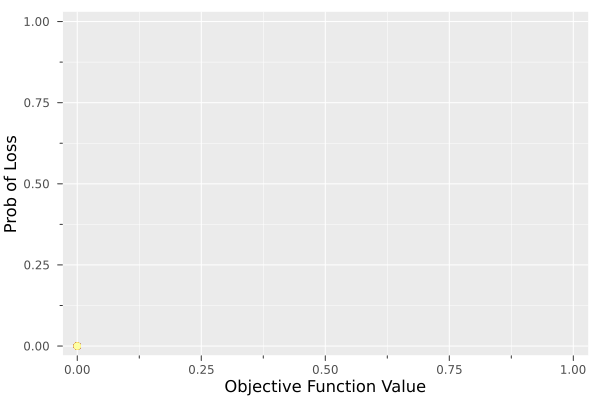

In [28]:
c = collect(1.0:1:length(Ns))

theme(:ggplot2)
scatter(objective_vals, loss_probs, zcolor=c, marker=:circle, xlabel="Objective Function Value", ylabel="Prob of Loss", zlabel="N", legend=false)
# xlims!(-.1,.1)  # Set the X-axis limits from 0 to 6
# ylims!(.45, .5) 

## Model 2/7
SAA with
- LogNormal
- γ = 0
- $\alpha$ = .1
- $\beta$ = .01
- N = [30, 40, 50, ..., 200] + 183      (Sample Sizes)